In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import numpy as np
import ase 
from ase.io import read
import json  
from ase.units import Hartree

In [3]:
torch.set_default_dtype(torch.float64) # set default dtype of torch to avoid numerical errors 

In [4]:
device = "cpu"

# Instantiate the Molecule Dataset 

In [5]:
from mlelec.data.dataset import MoleculeDataset

/home/suman/miniconda3/envs/qm7/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [6]:
molecule_data = MoleculeDataset(
    mol_name = "qm7",
    use_precomputed=True,
    path= "examples/data/qm7",
    aux_path="examples/data/qm7/sto-3g",
    frame_slice=slice(0, 1000),
    device=device,
    aux=["overlap", "orbitals"],
    target=["fock", "dipole_moment"],
)

Loading structures
examples/data/qm7/sto-3g/fock.hickle
examples/data/qm7/sto-3g/dipole_moment.hickle


### Create the ML dataset from the molecular data 

In [7]:
from mlelec.data.dataset import MLDataset

In [8]:
ml_data = MLDataset(
    molecule_data=molecule_data,
    device=device,
    model_strategy="coupled",
    shuffle=True, 
    shuffle_seed=5380,
)  

In [9]:
ml_data._split_indices(train_frac=0.7, val_frac=0.2, test_frac=0.1)

In [10]:
from mlelec.features.acdc import compute_features_for_target
from mlelec.data.dataset import get_dataloader

In [11]:
hypers = {
            "cutoff": 3.0,
            "max_radial" : 6,
            "max_angular": 4,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }
hypers_pair = {
            "cutoff": 10.0,
            "max_radial" : 6,
            "max_angular": 4,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }

ml_data._set_features(compute_features_for_target(ml_data, device = device, hypers = hypers, hypers_pair = hypers_pair))

In [12]:
train_dl, val_dl, test_dl = get_dataloader(ml_data, model_return="blocks", batch_size=50)

In [13]:
import metatensor
from metatensor import Labels

# Helper function to drop blocks in the train, validation and test subset that have zero samples due to splitting of the dataset

def drop_zero_blocks(train_tensor, val_tensor, test_tensor):
    for i1,b1 in train_tensor.items():
        if b1.values.shape[0] == 0:
            train_tensor = metatensor.drop_blocks(train_tensor, Labels(i1.names, i1.values.reshape(1,-1)))
            
    for i2,b2 in val_tensor.items():
        if b2.values.shape[0] == 0:
            val_tensor = metatensor.drop_blocks(val_tensor, Labels(i2.names, i2.values.reshape(1,-1)))
            
    for i3,b3 in test_tensor.items():
        if b3.values.shape[0] == 0:
            test_tensor = metatensor.drop_blocks(test_tensor, Labels(i3.names, i3.values.reshape(1,-1)))
            
    return train_tensor, val_tensor, test_tensor

In [14]:
ml_data.target_train, ml_data.target_val, ml_data.target_test = drop_zero_blocks(ml_data.target_train, ml_data.target_test)

In [15]:
ml_data.feat_train, ml_data.target_val, ml_data.feat_test = drop_zero_blocks(ml_data.feat_train, ml_data.feat_test)

# RidgeCV Model

In [16]:
from src.mlelec.models.linear import LinearTargetModel

### Fitting a RidgeCV model

In [17]:
model = LinearTargetModel(dataset = ml_data, nlayers = 1, nhidden = 16, bias = False, device = device)

In [18]:
pred_ridges, ridges = model.fit_ridge_analytical(alpha=np.logspace(-8, 3, 12), cv=3, set_bias=False)

### Calculating train and test errors for MO energies and dipoles

In [19]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, _to_matrix
    
uncoupled = _to_uncoupled_basis(pred_ridges,  device=model.device) # Convert the coupled blocks to uncoupled

# Recover the predicted matrices for the training set 
fock_predictions_train = _to_matrix(
    uncoupled,
    ml_data.train_frames,
    ml_data.train_idx,
    ml_data.aux_data['orbitals'],
    device=model.device,
)

In [70]:
import scipy as sp

def eig(focks, overlaps):
    eigvals = []
    for fock, overlap in zip(focks, overlaps):
        if isinstance(fock, torch.Tensor):
            fock = fock.detach().numpy()

        eigvals.append(sp.linalg.eigvalsh(fock, overlap))

    return eigvals

In [21]:
from mlelec.utils.twocenter_utils import fix_orbital_order
from ase.units import Hartree
import matplotlib.pyplot as plt

def mse_eigvals(pred_eva, eva):
    evanorm = []
    for i in range(len(pred_eva)):
        evanorm.append(np.mean((pred_eva[i] - eva[i])**2)/len(pred_eva[i]))
    return np.mean(evanorm)


In [22]:
target_fock = fix_orbital_order(ml_data.molecule_data.target['fock'], ml_data.structures, ml_data.aux_data['orbitals'])
target_ovlp = fix_orbital_order(ml_data.aux_data['overlap'], ml_data.structures, ml_data.aux_data['orbitals'])

pred_eva = eig(fock_predictions_train, target_ovlp[ml_data.train_idx])
eva = eig(target_fock[ml_data.train_idx], target_ovlp[ml_data.train_idx])

eva = np.array(eva, dtype=object)
pred_eva = np.array(pred_eva, dtype=object)

print("Train RMSE for MO_energies in eV: ", np.sqrt(mse_eigvals(pred_eva, eva))*Hartree)

Train RMSE for MO_energies in eV:  0.11819936083277252


In [24]:
pred_test = model.predict_ridge_analytical(ml_data.target_test, ml_data.feat_test)

In [25]:
test_uncoupled = _to_uncoupled_basis(pred_test,  device=model.device) # Convert the coupled blocks to uncoupled
fock_predictions_test = _to_matrix(
test_uncoupled,
    ml_data.test_frames,
    ml_data.test_idx,
    ml_data.aux_data['orbitals'],
    device=model.device,
)

In [26]:
test_pred_eva = eig(fock_predictions_test, target_ovlp[ml_data.test_idx])
test_eva = eig(target_fock[ml_data.test_idx], target_ovlp[ml_data.test_idx])

test_eva = np.array(test_eva, dtype=object)
test_pred_eva = np.array(test_pred_eva, dtype=object)

print("Test RMSE for MO_energies in eV: ", np.sqrt(mse_eigvals(test_pred_eva, test_eva))*Hartree)

Test RMSE for MO_energies in eV:  0.12183022876831233


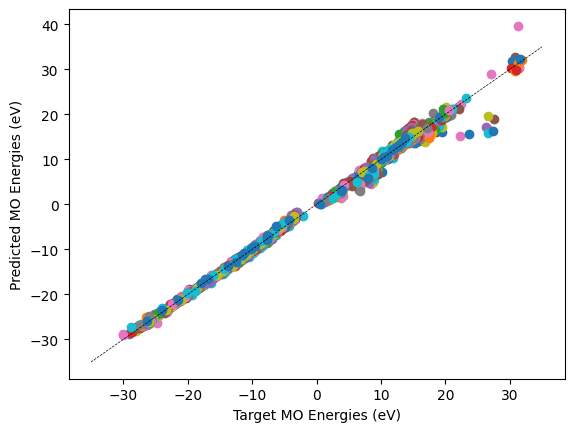

In [27]:
for target, predicted in zip(test_eva, test_pred_eva):
    x = target * Hartree
    y = predicted * Hartree
    
    x = x[x>-100]
    y = y[y>-100]
    plt.scatter(x,y)
    
plt.plot([-35,35], [-35,35], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target MO Energies (eV)')
plt.ylabel('Predicted MO Energies (eV)')
plt.show()

In [28]:
from IPython.utils import io
import mlelec.metrics as mlmetrics
from src.mlelec.utils.dipole_utils import *

Using PyTorch backend.


In [29]:
fock_predictions_train_unfix = unfix_orbital_order(
    fock_predictions_train,
    ml_data.train_frames,
    ml_data.molecule_data.aux_data["orbitals"],
)

with io.capture_output() as captured:
    
    dipole_predictions_train = compute_dipole_moment(
        ml_data.train_frames,
        fock_predictions_train_unfix,
        ml_data.molecule_data.aux_data["overlap"][ml_data.train_idx],
    )
    
error = mlmetrics.L2_loss(
    dipole_predictions_train, torch.from_numpy(ml_data.molecule_data.target["dipole_moment"][ml_data.train_idx].astype(np.float64))
)
print("Train RMSE on dipole in A.U.:", (torch.sqrt(error / len(dipole_predictions_train))).item())

Train RMSE on dipole in A.U.: 0.296814574493445


In [30]:
with io.capture_output() as captured:
    # convert prediction back to pyscf order
    fock_predictions_test_unfix = unfix_orbital_order(
        fock_predictions_test,
        ml_data.test_frames,
        ml_data.molecule_data.aux_data["orbitals"],
    )

    dipole_predictions_test = compute_dipole_moment(
        ml_data.test_frames,
        fock_predictions_test_unfix,
        ml_data.molecule_data.aux_data["overlap"][ml_data.test_idx],
    )

error = mlmetrics.L2_loss(
    dipole_predictions_test, torch.from_numpy(ml_data.molecule_data.target["dipole_moment"][ml_data.test_idx].astype(np.float64))
)
print("Test RMSE on dipole in A.U.:", (torch.sqrt(error / len(dipole_predictions_test))).item())

Test RMSE on dipole in A.U.: 0.3146047831255088


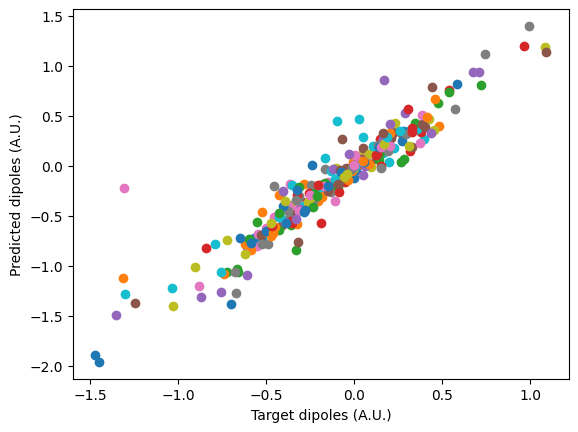

In [31]:
for predicted, target in zip(dipole_predictions_test.detach().numpy(), ml_data.molecule_data.target["dipole_moment"][ml_data.test_idx]):
    x = target
    y = predicted
    plt.scatter(x,y)
    
# plt.plot([-2,2], [-2,2], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target dipoles (A.U.)')
plt.ylabel('Predicted dipoles (A.U.)')
plt.show()

## Indirect learning of dipoles via bacprop using `PySCFAD`

In [32]:
import os
os.environ["PYSCFAD_BACKEND"] = "torch"
import torch
from torch.autograd.functional import jacobian
from pyscf import gto
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
from tqdm import tqdm

In [33]:
with io.capture_output() as captured:
    all_mfs, fockvars = instantiate_mf(
        ml_data,
        fock_predictions=None,
        batch_indices=list(range(len(ml_data.structures))),
    )

In [34]:
from cmath import inf
best = inf
early_stop_criteria = 50

In [50]:
# Do this only if you want to start your indirect training from the Ridge fitted weights
train_pred = model.forward(ml_data.feat_train, return_type="tensor", batch_indices=ml_data.train_idx, ridge_fit=True)

In [52]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=20, verbose=True
)

val_interval = 10
loss_fn = getattr(mlmetrics, "L2_loss") 
losses = []
early_stop_count = 0
nepochs = 800

In [48]:
from mlelec.utils.twocenter_utils import _lowdin_orthogonalize

def compute_eigvals(ml_data, focks, batch_indices):
    batch_frames = [ml_data.structures[i] for i in batch_indices]
    batch_fock = unfix_orbital_order(
        focks, batch_frames, ml_data.molecule_data.aux_data["orbitals"]
    )
    batch_overlap = ml_data.molecule_data.aux_data["overlap"][batch_indices]
    ortho_focks = [_lowdin_orthogonalize(f, torch.from_numpy(o)) for f, o in zip(batch_fock, batch_overlap)]
    eva = []
    for i in range(len(focks)):
        eva.append(torch.linalg.eigvalsh(ortho_focks[i]))
    return eva

In [62]:
iterator = tqdm(range(500))

for epoch in iterator:
    model.train(True)
    train_loss = 0
    for data in train_dl:
        optimizer.zero_grad()
        idx = data["idx"]

        #forward pass
        pred = model(data["input"], return_type="tensor", batch_indices=[i.item() for i in idx])
        train_dip_pred = compute_batch_dipole_moment(
            ml_data, pred, batch_indices=idx, mfs=all_mfs
        )
        dip = torch.from_numpy(ml_data.molecule_data.target["dipole_moment"][idx].astype(np.float64))
        
        loss = loss_fn(train_dip_pred, dip)
        train_loss += loss.item()
        
        # backward pass
        loss.backward()
        optimizer.step()

    losses.append(train_loss)
    scheduler.step(train_loss)
    
    model.train(False)

    if epoch % val_interval == 0:
        val_loss = 0
        for i, data in enumerate(val_dl):
            idx = data["idx"]
            val_pred = model(data["input"], return_type="tensor", batch_indices=[i.item() for i in idx])
            with io.capture_output() as captured:
                val_dip_pred = compute_batch_dipole_moment(
                    ml_data, val_pred, batch_indices=idx, mfs=all_mfs
                )
            val_dip = torch.from_numpy(ml_data.molecule_data.target["dipole_moment"][idx].astype(np.float64))
            vloss = loss_fn(val_dip_pred, val_dip)
            val_loss += vloss.item()
        new_best = val_loss < best
        if new_best:
            best = val_loss
            # torch.save(model.state_dict(), 'best_model_dipole.pt')
            early_stop_count = 0
        else:
            early_stop_count += 1
        if early_stop_count > early_stop_criteria:
            print(f"Early stopping at epoch {epoch}")
            print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

            print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")
            # Save last best model
            break

    if epoch % 1 == 0:
        iterator.set_postfix(train_loss = train_loss/len(ml_data.train_idx), Val_loss = val_loss/len(ml_data.val_idx))

 53%|█████▎    | 264/500 [16:58:08<15:10:09, 231.39s/it, Val_loss=0.00449, train_loss=5.95e-5]


KeyboardInterrupt: 

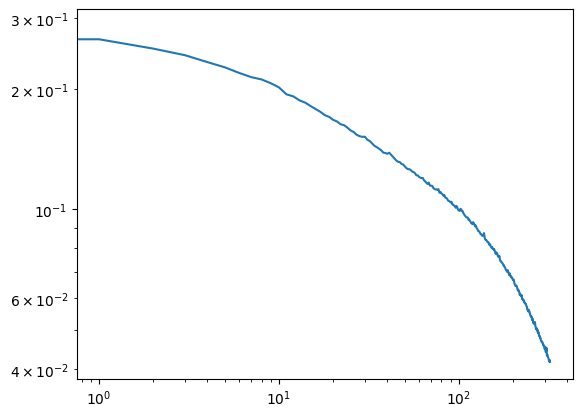

In [63]:
from matplotlib import pyplot as plt
plt.loglog(losses)

In [64]:
with io.capture_output() as captured:
    batch_indices = ml_data.train_idx
    train_fock_predictions = model.forward(
        ml_data.feat_train, return_type="tensor", batch_indices=batch_indices
    )
    train_dip_pred = compute_batch_dipole_moment(
        ml_data, train_fock_predictions, batch_indices=batch_indices, mfs=all_mfs
    )

error = mlmetrics.L2_loss(
    train_dip_pred, torch.from_numpy(ml_data.molecule_data.target["dipole_moment"][batch_indices].astype(np.float64))
)
print("Train MSE on dipole", torch.sqrt(error / len(train_dip_pred)))

Train MSE on dipole tensor(0.0076, grad_fn=<SqrtBackward0>)


In [ ]:
with io.capture_output() as captured:
    batch_indices = ml_data.test_idx
    test_fock_predictions = model.forward(
        ml_data.feat_test, return_type="tensor", batch_indices=ml_data.test_idx,
    )
    test_dip_pred = compute_batch_dipole_moment(
        ml_data, test_fock_predictions, batch_indices=batch_indices, mfs=all_mfs
    )

error = mlmetrics.L2_loss(
    test_dip_pred, torch.from_numpy(ml_data.molecule_data.target["dipole_moment"][batch_indices].astype(np.float64))
)

In [105]:
print("Test RMSE on dipole from indirect learning {:.5f} A.U.".format(torch.sqrt(error / len(test_dip_pred)).item()))

Test RMSE on dipole from indirect learning 0.08608 A.U.


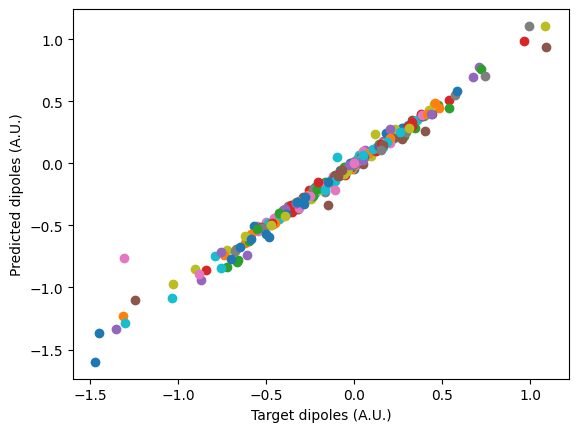

In [67]:
for predicted, target in zip(test_dip_pred.detach().numpy(), ml_data.molecule_data.target["dipole_moment"][ml_data.test_idx]):
    x = target
    y = predicted
    plt.scatter(x,y)
    
# plt.plot([-2,2], [-2,2], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target dipoles (A.U.)')
plt.ylabel('Predicted dipoles (A.U.)')
plt.show()

In [80]:
from src.mlelec.utils.dipole_utils import *

test_eva_pred_ind = compute_batch_eva(
        ml_data, test_fock_predictions, batch_indices=batch_indices, mfs=all_mfs
    )
test_eva_ref = compute_eigvals(ml_data, [ml_data.target.tensor[i] for i in batch_indices], batch_indices)

In [107]:
print("Test RMSE on MO energies after indirect learning on dipoles {:.5f} eV ".format(torch.sqrt(loss_fn(test_eva_pred_ind, x)).item()*Hartree))

Test RMSE on MO energies after indirect learning on dipoles 8.96578 eV 


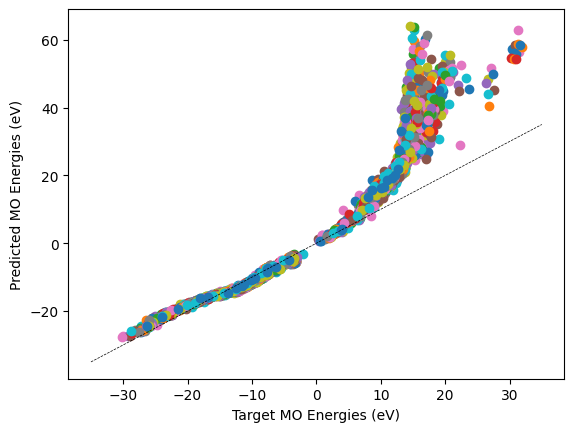

In [92]:
for target, predicted in zip(test_eva, test_eva_pred_ind):
    x = target * Hartree
    y = predicted.detach().numpy() * Hartree
    
    x = x[x>-100]
    y = y[y>-100]
    plt.scatter(x,y)
    
plt.plot([-35,35], [-35,35], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target MO Energies (eV)')
plt.ylabel('Predicted MO Energies (eV)')
plt.show()